In [ ]:
import numpy as np

class Distance_smoother:
    def __init__(self, n_lanes, proc_noise_scale, meas_noise_scale, process_cov_parallel=0, proc_noise_type='white'):
        self.n_lanes = n_lanes
        self.meas_size = 4 * self.n_lanes
        self.state_size = self.meas_size * 2
        self.contr_size = 0

        self.kf = cv2.KalmanFilter(self.state_size, self.meas_size, self.contr_size)
        self.kf.transitionMatrix = np.eye(self.state_size, dtype=np.float32)
        self.kf.measurementMatrix = np.zeros((self.meas_size, self.state_size), np.float32)
        for i in range(self.meas_size):
            self.kf.measurementMatrix[i, i*2] = 1

        if proc_noise_type == 'white':
            block = np.matrix([[0.25, 0.5],
                               [0.5, 1.]], dtype=np.float32)
            self.kf.processNoiseCov = block_diag(*([block] * self.meas_size)) * proc_noise_scale
        if proc_noise_type == 'identity':
            self.kf.processNoiseCov = np.eye(self.state_size, dtype=np.float32) * proc_noise_scale
        for i in range(0, self.meas_size, 2):
            for j in range(1, self.n_lanes):
                self.kf.processNoiseCov[i, i+(j*8)] = process_cov_parallel
                self.kf.processNoiseCov[i+(j*8), i] = process_cov_parallel

        self.kf.measurementNoiseCov = np.eye(self.meas_size, dtype=np.float32) * meas_noise_scale

        self.kf.errorCovPre = np.eye(self.state_size)

        self.meas = np.zeros((self.meas_size, 1), np.float32)
        self.state = np.zeros((self.state_size, 1), np.float32)

        self.first_detected = False

    def _update_dt(self, dt):
        for i in range(0, self.state_size, 2):
            self.kf.transitionMatrix[i, i+1] = dt

    def _first_detect(self, lanes):
        for l, i in zip(lanes, range(0, self.state_size, 8)):
            self.state[i:i+8:2, 0] = l
        self.kf.statePost = self.state
        self.first_detected = True

    def update(self, lanes):
        if self.first_detected:
            for l, i in zip(lanes, range(0, self.meas_size, 4)):
                if l is not None:
                    self.meas[i:i+4, 0] = l
            self.kf.correct(self.meas)
        else:
            if lanes.count(None) == 0:
                self._first_detect(lanes)

    def predict(self, dt):
        if self.first_detected:
            self._update_dt(dt)
            state = self.kf.predict()
            lanes = []
            for i in range(0, len(state), 8):
                lanes.append((state[i], state[i+2], state[i+4], state[i+6]))
            return lanes
        else:
            return None

In [ ]:
import cv2, numpy as np

meas=[]
pred=[]
frame = np.zeros((400,400,3), np.uint8) # drawing canvas
mp = np.array((2,1), np.float32) # measurement
tp = np.zeros((2,1), np.float32) # tracked / prediction

def onmouse(k,x,y,s,p):
    global mp,meas
    mp = np.array([[np.float32(x)],[np.float32(y)]])
    meas.append((x,y))

def paint():
    global frame,meas,pred
    for i in range(len(meas)-1): cv2.line(frame,meas[i],meas[i+1],(0,100,0))
    for i in range(len(pred)-1): cv2.line(frame,pred[i],pred[i+1],(0,0,200))

def reset():
    global meas,pred,frame
    meas=[]
    pred=[]
    frame = np.zeros((400,400,3), np.uint8)

cv2.namedWindow("kalman")
cv2.setMouseCallback("kalman",onmouse);
kalman = cv2.KalmanFilter(4,2)
kalman.measurementMatrix = np.array([[1,0,0,0],[0,1,0,0]],np.float32)
kalman.transitionMatrix = np.array([[1,0,1,0],[0,1,0,1],[0,0,1,0],[0,0,0,1]],np.float32)
kalman.processNoiseCov = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]],np.float32) * 0.03
kalman.measurementNoiseCov = np.array([[1,0],[0,1]],np.float32) * 0.00003
while True:
    kalman.correct(mp)
    tp = kalman.predict()
    pred.append((int(tp[0]),int(tp[1])))
    paint()
    cv2.imshow("kalman",frame)
    k = cv2.waitKey(30) &0xFF

(100, 100)


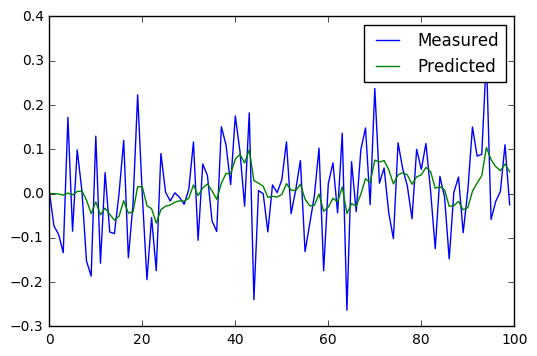

In [24]:
import cv2, numpy as np
import time, random
import matplotlib 
import matplotlib.pyplot as plt

meas=[]
pred=[]
mp = np.array((1,1),np.float32) # measurement
tp = np.zeros((1,1),np.float32) # tracked / prediction

kalman = cv2.KalmanFilter(2,1) # 2D state (distance and velocity), 1D measurement (distance)
kalman.measurementMatrix = np.array([[1,1]], np.float32)
kalman.transitionMatrix = np.array([[1,1], [0,1]], np.float32)
kalman.processNoiseCov = np.array([[1,0], [0,1]], np.float32) * 0.00003
kalman.measurementNoiseCov = np.array([[1]], np.float32) * 0.03

steps = 100
for i in range(steps):
        mp = np.array([[np.random.normal(0, 0.1)]], np.float32)
        meas.append(mp[0])
        kalman.correct(mp)
        tp = kalman.predict()
        pred.append(tp[0])
        #print("Measured: %s, estimated: %s" % (mp[0], tp[0]))
        #time.sleep(0.1)

time = np.arange(0, steps)
print(len(time), len(meas))
meas_lab, = plt.plot(time, meas, label = "Measured")
est_lab, = plt.plot(time, pred, label = "Predicted")

plt.legend(handles=[meas_lab, est_lab])
plt.show()

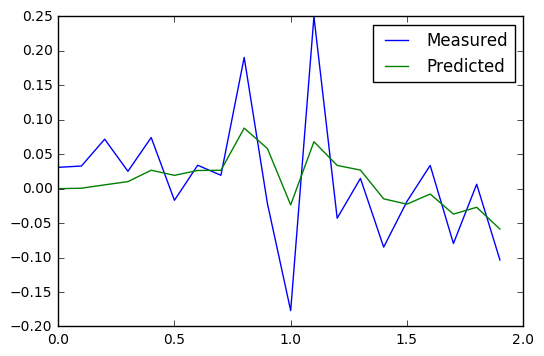

In [ ]:
import cv2, numpy as np
import time

meas=[]
pred=[]
# frame = np.zeros((400,400,3), np.uint8) # drawing canvas
mp = np.array((2,1), np.float32) # measurement
tp = np.zeros((2,1), np.float32) # tracked / prediction

# def onmouse(k,x,y,s,p):
#     global mp,meas
#     mp = np.array([[np.float32(x)],[np.float32(y)]])
#     meas.append((x,y))

# def paint():
#     global frame,meas,pred
#     for i in range(len(meas)-1): cv2.line(frame,meas[i],meas[i+1],(0,100,0))
#     for i in range(len(pred)-1): cv2.line(frame,pred[i],pred[i+1],(0,0,200))

# def reset():
#     global meas,pred,frame
#     meas=[]
#     pred=[]
#     frame = np.zeros((400,400,3), np.uint8)

# cv2.namedWindow("kalman")
# cv2.setMouseCallback("kalman",onmouse);
kalman = cv2.KalmanFilter(4,2)
kalman.measurementMatrix = np.array([[1,0,0,0],[0,1,0,0]],np.float32)
kalman.transitionMatrix = np.array([[1,0,1,0],[0,1,0,1],[0,0,1,0],[0,0,0,1]],np.float32)
kalman.processNoiseCov = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]],np.float32) * 0.03
kalman.measurementNoiseCov = np.array([[1,0],[0,1]],np.float32) * 0.00003
while True:
    mp = np.array([[np.random.normal(0, 1)], [np.random.normal(0, 1)]], np.float32)
    kalman.correct(mp)
    tp = kalman.predict()
    pred.append((int(tp[0]),int(tp[1])))
    print(tp[0], tp[1])
    time.sleep(0.1)
#     paint()
#     cv2.imshow("kalman",frame)
#     k = cv2.waitKey(30) &0xFF

(array([ 0.], dtype=float32), array([ 0.], dtype=float32))
(array([ 0.61134046], dtype=float32), array([-1.08743989], dtype=float32))
(array([ 0.2958554], dtype=float32), array([-2.6246593], dtype=float32))
(array([ 0.30951554], dtype=float32), array([-1.35246313], dtype=float32))
(array([ 0.17871554], dtype=float32), array([ 0.91755873], dtype=float32))
(array([ 2.29008293], dtype=float32), array([ 3.65192795], dtype=float32))
(array([ 0.09781206], dtype=float32), array([-0.74807799], dtype=float32))
(array([-1.9373064], dtype=float32), array([ 1.15032983], dtype=float32))
(array([-0.7121911], dtype=float32), array([-0.06077586], dtype=float32))
(array([ 0.00908703], dtype=float32), array([-1.77043343], dtype=float32))
(array([ 2.52209616], dtype=float32), array([ 0.79325616], dtype=float32))
(array([ 1.38521731], dtype=float32), array([-0.31208879], dtype=float32))
(array([-1.88951468], dtype=float32), array([-0.02941464], dtype=float32))
(array([-0.94349432], dtype=float32), array([

In [10]:
print([np.random.normal(0,1,2))

[ 1.79654114  0.72623418]


In [5]:
import sys
PY3 = sys.version_info[0] == 3

if PY3:
    long = int

import cv2
from math import cos, sin, sqrt
import numpy as np

if __name__ == "__main__":

    img_height = 500
    img_width = 500
    kalman = cv2.KalmanFilter(2, 1, 0)

    code = long(-1)

    cv2.namedWindow("Kalman")

    while True:
        state = 0.1 * np.random.randn(2, 1)

        kalman.transitionMatrix = np.array([[1., 1.], [0., 1.]])
        kalman.measurementMatrix = 1. * np.ones((1, 2))
        kalman.processNoiseCov = 1e-5 * np.eye(2)
        kalman.measurementNoiseCov = 1e-1 * np.ones((1, 1))
        kalman.errorCovPost = 1. * np.ones((2, 2))
        kalman.statePost = 0.1 * np.random.randn(2, 1)

        while True:
            def calc_point(angle):
                return (np.around(img_width/2 + img_width/3*cos(angle), 0).astype(int),
                        np.around(img_height/2 - img_width/3*sin(angle), 1).astype(int))

            state_angle = state[0, 0]
            state_pt = calc_point(state_angle)

            prediction = kalman.predict()
            predict_angle = prediction[0, 0]
            predict_pt = calc_point(predict_angle)

            measurement = kalman.measurementNoiseCov * np.random.randn(1, 1)

            # generate measurement
            measurement = np.dot(kalman.measurementMatrix, state) + measurement
            print(measurement)
            measurement_angle = measurement[0, 0]
            measurement_pt = calc_point(measurement_angle)

            # plot points
            def draw_cross(center, color, d):
                cv2.line(img,
                         (center[0] - d, center[1] - d), (center[0] + d, center[1] + d),
                         color, 1, cv2.LINE_AA, 0)
                cv2.line(img,
                         (center[0] + d, center[1] - d), (center[0] - d, center[1] + d),
                         color, 1, cv2.LINE_AA, 0)

            img = np.zeros((img_height, img_width, 3), np.uint8)
            draw_cross(np.int32(state_pt), (255, 255, 255), 3)
            draw_cross(np.int32(measurement_pt), (0, 0, 255), 3)
            draw_cross(np.int32(predict_pt), (0, 255, 0), 3)

            cv2.line(img, state_pt, measurement_pt, (0, 0, 255), 3, cv2.LINE_AA, 0)
            cv2.line(img, state_pt, predict_pt, (0, 255, 255), 3, cv2.LINE_AA, 0)

            kalman.correct(measurement)

            process_noise = sqrt(kalman.processNoiseCov[0,0]) * np.random.randn(2, 1)
            state = np.dot(kalman.transitionMatrix, state) + process_noise

            cv2.imshow("Kalman", img)

            code = cv2.waitKey(100)
            if code != -1:
                break

        if code in [27, ord('q'), ord('Q')]:
            break

    cv2.destroyWindow("Kalman")

[[-0.05492779]]
[[ 0.02905413]]
[[-0.20771289]]
[[-0.19326402]]
[[-0.38170869]]
[[-0.13528774]]
[[-0.50518911]]
[[-0.37849628]]
[[-0.34807672]]
[[-0.48325376]]
[[-0.41787493]]
[[-0.45655272]]
[[-0.66376829]]
[[-0.5791688]]
[[-0.59419624]]
[[-0.66649812]]
[[-0.86462725]]
[[-0.83356383]]
[[-1.02272075]]
[[-0.90459787]]
[[-0.92289436]]
[[-0.89400613]]
[[-0.92321621]]
[[-1.02869696]]
[[-1.04726756]]
[[-1.10928516]]
[[-1.19457181]]
[[-1.26867315]]
[[-1.32436053]]
[[-1.38835268]]
[[-1.3050962]]
[[-1.49453999]]
[[-1.59496225]]
[[-1.71007169]]
[[-1.70023864]]
[[-1.96430283]]
[[-1.75525663]]
[[-1.94278817]]
[[-1.88180961]]
[[-2.16376462]]
[[-2.10298087]]
[[-2.38200691]]
[[-2.3670838]]
[[-2.3079362]]
[[-2.57719575]]
[[-2.30768203]]
[[-2.52134847]]
[[-2.5428964]]
[[-2.77266116]]
[[-2.83861965]]
[[ 0.02809415]]
[[ 0.02021532]]
[[-0.00059952]]
[[ 0.03071628]]
[[ 0.2235713]]
[[ 0.1983372]]


In [17]:
from filterpy.kalman import KalmanFilter
f = KalmanFilter (dim_x=2, dim_z=1)

ImportError: No module named filterpy.kalman